In [3]:
# firestoreの初期化
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

cred = credentials.Certificate('./firebase-config.json')
firebase_admin.initialize_app(cred)

db = firestore.client()

In [4]:
# エラーログを全取得してlogsにつめる
import datetime
users_ref = db.collection(u'logs')
docs = users_ref.where('time', '>', datetime.datetime(year=2020, month=1, day=22)).where('time', '<', datetime.datetime(year=2020, month=1, day=23)).stream()
logs = []

for doc in docs:
    logs.append(doc.to_dict())
    print(u'{} => {}'.format(doc.id, doc.to_dict()))

=> {'time': DatetimeWithNanoseconds(2020, 1, 22, 5, 42, 12, 505000, tzinfo=<UTC>), 'value': [{'params': None, 'subject': ']', 'type': 'error', 'time': 0, 'pos': 218, 'col': 32, 'len': 1, 'row': 9, 'key': 'SyntaxError'}], 'uid': 'Ch7q413mTofQl9BarWozYUfU1o63', 'type': 'compile-error'}
m7s8UEQANECdyvNGGQgq => {'uid': '2htaIavUQJOsIAfvxSNme37HU0M2', 'type': 'compile-error', 'time': DatetimeWithNanoseconds(2020, 1, 22, 5, 42, 13, 90000, tzinfo=<UTC>), 'value': [{'pos': 136, 'col': 0, 'len': 1, 'row': 5, 'key': 'SyntaxError', 'params': None, 'subject': '\n', 'type': 'error', 'time': 0}]}
Q0lCAze3sZVN6Mjetthy => {'value': [{'col': 0, 'len': 1, 'row': 5, 'key': 'SyntaxError', 'params': None, 'subject': '\n', 'type': 'error', 'time': 0, 'pos': 136}], 'uid': '2htaIavUQJOsIAfvxSNme37HU0M2', 'type': 'compile-error', 'time': DatetimeWithNanoseconds(2020, 1, 22, 5, 42, 14, 130000, tzinfo=<UTC>)}
gv9YQB4hwjP4NSbcrkf6 => {'uid': '2htaIavUQJOsIAfvxSNme37HU0M2', 'type': 'compile-error', 'time': Datetim

In [5]:
# エラーをuidから引ける辞書user2logsを作成

user2logs = {}

for log in logs:
    uid = log['uid']
    if uid in user2logs:
        user2logs[uid].append(log)
    else:
        user2logs[uid] = []

{'SyntaxError': 4632, 'UndefinedName': 1821, 'InferredPackage': 14, 'UndefinedFunction': 223, 'Zenkaku': 19, 'NLKeyValues': 29, 'BinaryTypeError': 4, 'TypeError': 79, 'RecoverP': 1, 'UnknownName': 101, 'Unsupported': 18, 'SyntaxError/List': 154}
['SyntaxError', 'UndefinedName', 'InferredPackage', 'UndefinedFunction', 'Zenkaku', 'NLKeyValues', 'BinaryTypeError', 'TypeError', 'RecoverP', 'UnknownName', 'Unsupported', 'SyntaxError/List']


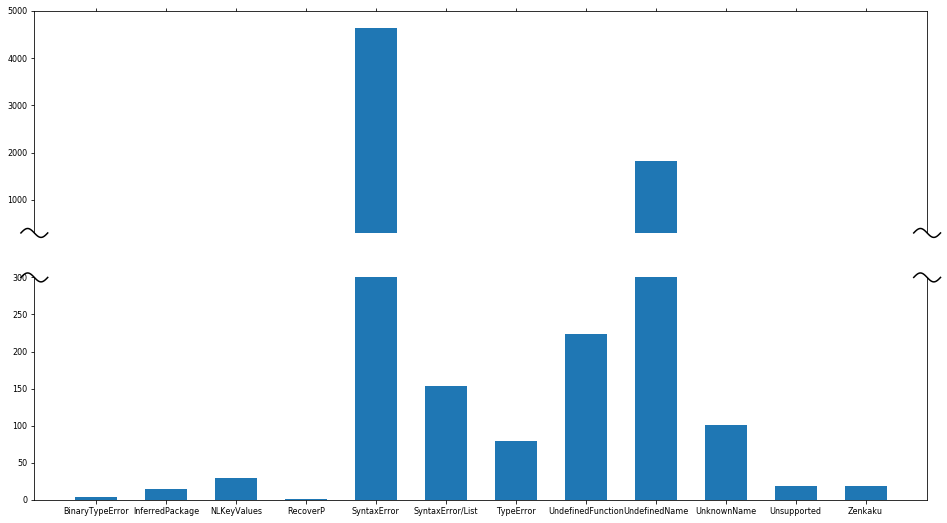

In [6]:
import matplotlib.pyplot as plt
import numpy as np

error_cnt = {}
for log in logs:
    if (log['type'] == 'compile-error'):
        for v in log['value']:
            error_key = v['key']
            if error_key in error_cnt:
                error_cnt[error_key] += 1
            else:
                error_cnt[error_key] = 1

print(error_cnt)
error_keys = list(error_cnt.keys())
print(error_keys)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 9))

ax1.bar(error_cnt.keys(), error_cnt.values(), width=0.6)
ax1.set_ylim(300, 5000)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')
ax1.tick_params(labelsize = 8)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)


d = .015

x1 = np.linspace(-d, +d, 100)
x2 = np.linspace(1 - d, 1 + d, 100)
y1 = np.sin(np.linspace(0, 2*np.pi, 100))/50
y2 = np.sin(np.linspace(0, 2*np.pi, 100))/50+1

kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot(x1, y1, **kwargs)
ax1.plot(x2, y1, **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot(x1, y2, **kwargs)
ax2.plot(x2, y2, **kwargs)

ax2.set_ylim(0, 300)
ax2.tick_params(labelsize = 8)
ax2.bar(error_cnt.keys(), error_cnt.values(), width=0.6)
fig.savefig('./data/png/error-logs.png')
fig

In [7]:
# 授業前アンケートと授業後アンケートを合体
import pandas as pd
ColumnNameMapper = {
    "タイムスタンプ": 'timestamp',
    "あなたがログインしたGmailアカウントを教えてください": "email",
    "パソコン（スマホ、タブレットを除く）をどの程度使いますか？": "pc_usage",
    "タイピングは得意ですか？": "typing",
    "プログラミングを体験したことはありますか？": "experience",
    "体験したプログラミング言語はなんでしたか？": "experience_langs",
    "体験したのはいつ頃、どのような機会でしたか？": "experience_timing",
    "どのくらいの時間体験しましたか？": "experience_time",
    "好きな教科は何ですか？好きな順に3つあげてください。": "favorite_subject",
    "プログラミングに関する印象を教えてください（複数選択可）": 'impression',
    "その他、授業を受けてプログラミングに関して印象が変わったことがあったら教えてください": 'impression_change',
    "プログラミングを学ぶと、数式を書いて計算できる": "able_calc",
    "プログラミングは、数式だけでなく、文字や画像などを扱うことができる": "able_char_image",
    "プログラムは、文法どおりに書かないと、正しくうごかない": "strict_syntax",
    "プログラミングは、数学だけでなく英語力（国語力）も重要である": "need_natural_lang",
    "プログラムは、上から順番に実行される": "run_from_head",
    "プログラミングは、繰り返し処理を簡単に実現できる": "easy_loop",
    "プログラミングは、どちらかと言えば、料理に似ている": "similar_cook",
    "もう少し練習すればいろいろできるようになりそう": "have_potency",
    "今回の授業を経験してさらに学びたいことがあったら書いてください": "want_learn",
    "Puppy の良かった点や悪かった点、気づいたことがあったら教えてください": "good_and_bad",
    "ドミノ倒しのプログラムを完成させることはできましたか？": 'finish_domino'
}
before_interview = pd.read_csv('./data/csv/before-interview.csv').rename(columns=ColumnNameMapper)
after_interview = pd.read_csv('./data/csv/after-interview.csv').rename(columns=ColumnNameMapper)
interview = pd.merge(before_interview, after_interview, on='email', how='outer', suffixes=('_before', '_after'))
interview

,timestamp_before,email,pc_usage,typing,experience,experience_langs,experience_timing,experience_time,favorite_subject,impression_before,...,able_char_image,strict_syntax,need_natural_lang,run_from_head,easy_loop,similar_cook,have_potency,want_learn,good_and_bad,finish_domino
0,1/22/2020 13:31:31,yuimuha68@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"数学,歴史,家庭科",絶対に勉強したくない,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/22/2020 13:31:42,xxx.drop813@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"美術,数学,英語",勉強したいけど、私には難しそう,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/22/2020 13:33:19,matomy1006@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"体育,家庭科,音楽",特殊な人たちがマスターすべきもの,...,いいえ,はい,はい,わからない,はい,いいえ,はい,迷路みたいなものを作ってみたいと思った,色もかわいくて楽しく学ぶことができた,あともう少しでできそうだった
3,1/22/2020 13:33:29,kaorim0929@gmail.com,1学期で数回（レポートを書く時のみ）,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"家庭科,歴史,体育","勉強しないと時代に取り残されそう, 勉強したいけど、私には難しそう",...,わからない,はい,わからない,はい,はい,はい,わからない,NaN,カラフルでかわいかった,うまくできなかった
4,1/22/2020 13:33:45,nottorimichan@gmail.com,毎日,タッチタイピング（ブラインドタッチ）ができる,ない,NaN,NaN,NaN,"家庭科,数学,英語",勉強してみたい,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1/22/2020 13:34:18,m.c.coco66@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"体育,音楽,児童文化",勉強してみたい,...,はい,はい,わからない,はい,はい,はい,はい,もっと自由自在に動かすことが出来るようになりたいです。,NaN,できた
6,1/22/2020 13:34:19,mocomoco.120123@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"音楽,体育,世界史","勉強しないと時代に取り残されそう, 勉強したいけど、私には難しそう",...,はい,はい,わからない,はい,はい,わからない,わからない,NaN,NaN,うまくできなかった
7,1/22/2020 13:34:26,momoirodream9863@gmail.com,1学期で数回（レポートを書く時のみ）,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"音楽,歴史,体育","勉強しないと時代に取り残されそう, 勉強したいけど、私には難しそう",...,はい,はい,はい,はい,はい,わからない,はい,NaN,NaN,あともう少しでできそうだった
8,1/22/2020 13:34:30,maiyui2814@gmail.com,1学期で数回（レポートを書く時のみ）,タッチタイピングはできないが、キーボード入力に不自由を感じない,ない,NaN,NaN,NaN,"体育,音楽,理科","勉強したいけど、私には難しそう, 特殊な人たちがマスターすべきもの",...,はい,はい,はい,はい,はい,わからない,はい,NaN,説明がわかりやすかった。,できた
9,1/22/2020 13:34:31,tdr.010104@gmail.com,1学期で数回（レポートを書く時のみ）,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"体育,音楽,技術",特殊な人たちがマスターすべきもの,...,はい,はい,はい,はい,はい,わからない,はい,NaN,色がかわいい!!!!!!!!!,できた


In [8]:
# interviewにGoogleアカウントのUIDを突っ込んでおく
users_ref = db.collection(u'users')
docs = users_ref.stream()

users = {'email': [], 'uid': []}

for doc in docs:
    user = doc.to_dict()
    users['email'].append(user['email'])
    users['uid'].append(user['uid'])

users_df = pd.DataFrame(users)
interview = pd.merge(interview, users_df, on='email', how='left')
interview

,timestamp_before,email,pc_usage,typing,experience,experience_langs,experience_timing,experience_time,favorite_subject,impression_before,...,strict_syntax,need_natural_lang,run_from_head,easy_loop,similar_cook,have_potency,want_learn,good_and_bad,finish_domino,uid
0,1/22/2020 13:31:31,yuimuha68@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"数学,歴史,家庭科",絶対に勉強したくない,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XaqGToNu7cexBoIRb6ACGyOkrpE2
1,1/22/2020 13:31:42,xxx.drop813@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"美術,数学,英語",勉強したいけど、私には難しそう,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c3Idh8EfTkdYrpP0dEmTpNRbfcw1
2,1/22/2020 13:33:19,matomy1006@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"体育,家庭科,音楽",特殊な人たちがマスターすべきもの,...,はい,はい,わからない,はい,いいえ,はい,迷路みたいなものを作ってみたいと思った,色もかわいくて楽しく学ぶことができた,あともう少しでできそうだった,2htaIavUQJOsIAfvxSNme37HU0M2
3,1/22/2020 13:33:29,kaorim0929@gmail.com,1学期で数回（レポートを書く時のみ）,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"家庭科,歴史,体育","勉強しないと時代に取り残されそう, 勉強したいけど、私には難しそう",...,はい,わからない,はい,はい,はい,わからない,NaN,カラフルでかわいかった,うまくできなかった,oSs8zQoRVAfA025XuAAkXkEd5Ct2
4,1/22/2020 13:33:45,nottorimichan@gmail.com,毎日,タッチタイピング（ブラインドタッチ）ができる,ない,NaN,NaN,NaN,"家庭科,数学,英語",勉強してみたい,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAWrjO4OOeWpLVZxmguIcqCWM132
5,1/22/2020 13:34:18,m.c.coco66@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"体育,音楽,児童文化",勉強してみたい,...,はい,わからない,はい,はい,はい,はい,もっと自由自在に動かすことが出来るようになりたいです。,NaN,できた,1UMvJr5ROnTAd2GRTAKIueZawZf1
6,1/22/2020 13:34:19,mocomoco.120123@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"音楽,体育,世界史","勉強しないと時代に取り残されそう, 勉強したいけど、私には難しそう",...,はい,わからない,はい,はい,わからない,わからない,NaN,NaN,うまくできなかった,P2KigXGeADWDOxEH0F7netBYG7n2
7,1/22/2020 13:34:26,momoirodream9863@gmail.com,1学期で数回（レポートを書く時のみ）,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"音楽,歴史,体育","勉強しないと時代に取り残されそう, 勉強したいけど、私には難しそう",...,はい,はい,はい,はい,わからない,はい,NaN,NaN,あともう少しでできそうだった,DyEsn3aY4bZOjHdjvKZdPbWmTWc2
8,1/22/2020 13:34:30,maiyui2814@gmail.com,1学期で数回（レポートを書く時のみ）,タッチタイピングはできないが、キーボード入力に不自由を感じない,ない,NaN,NaN,NaN,"体育,音楽,理科","勉強したいけど、私には難しそう, 特殊な人たちがマスターすべきもの",...,はい,はい,はい,はい,わからない,はい,NaN,説明がわかりやすかった。,できた,eF1lONR9Sea4ZVv3vG6aXuYYgsk2
9,1/22/2020 13:34:31,tdr.010104@gmail.com,1学期で数回（レポートを書く時のみ）,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"体育,音楽,技術",特殊な人たちがマスターすべきもの,...,はい,はい,はい,はい,わからない,はい,NaN,色がかわいい!!!!!!!!!,できた,z2NTghSK4pMOdRefCvPOYhwyW7I2


In [9]:
# プログラミングに関する印象を比較
df = interview.dropna(subset=['impression_before', 'impression_after'])

impression_ba = {}
count_ba = {'before': {}, 'after': {}}
count_before_item = 0
count_after_item = 0

for item in df.iterrows():
    impression_before = item[1]['impression_before']
    impression_after = item[1]['impression_after']
    impression_before = impression_before.replace(" ", "")
    impression_after = impression_after.replace(" ", "")
    for item in impression_before.split(','):
        count_before_item += 1
        if item in count_ba['before']:
            count_ba['before'][item] += 1
        else:
            count_ba['before'][item] = 1
    for item in impression_after.split(','):
        count_after_item += 1
        if item in count_ba['after']:
            count_ba['after'][item] += 1
        else:
            count_ba['after'][item] = 1
    if (impression_before in impression_ba) and (impression_after in impression_ba[impression_before]):
        impression_ba[impression_before][impression_after] += 1
    elif impression_before in impression_ba:
        impression_ba[impression_before][impression_after] = 1
    else:
        impression_ba[impression_before] = {impression_after: 1}

for key, value in impression_ba.items():
    print(key)
    for k, v in value.items():
        print('\t' + k + ' => ' + f'{v}')

特殊な人たちがマスターすべきもの
	勉強してみたい,勉強したいけど、私には難しそう => 1
	勉強してみたい => 1
	特殊な人たちがマスターすべきもの,意外と出来た => 1
	勉強したいけど、私には難しそう => 1
勉強しないと時代に取り残されそう,勉強したいけど、私には難しそう
	勉強しないと時代に取り残されそう,勉強したいけど、私には難しそう => 3
	勉強したいけど、私には難しそう => 2
	勉強してみたい,勉強しないと時代に取り残されそう,勉強したいけど、私には難しそう => 1
	これこそ人生 => 1
勉強してみたい
	勉強してみたい => 3
勉強したいけど、私には難しそう,特殊な人たちがマスターすべきもの
	勉強してみたい => 3
勉強したいけど、私には難しそう
	勉強したいけど、私には難しそう => 4
	勉強してみたい => 3
	勉強しないと時代に取り残されそう,勉強したいけど、私には難しそう => 1
	これこそ人生,勉強してみたい => 1
	勉強しないと時代に取り残されそう => 1
特殊な人たちがマスターすべきもの,絶対に勉強したくない
	勉強しないと時代に取り残されそう,勉強したいけど、私には難しそう => 1
	特殊な人たちがマスターすべきもの => 1
勉強しないと時代に取り残されそう,勉強したいけど、私には難しそう,覚えることがたくさんありそう
	勉強しないと時代に取り残されそう => 1
勉強しないと時代に取り残されそう,勉強したいけど、私には難しそう,勉強してなにに役立つのかがわからない
	自分が思い描いたように動くとうれしい => 1
勉強してみたい,勉強しないと時代に取り残されそう,勉強したいけど、私には難しそう
	勉強してみたい,勉強しないと時代に取り残されそう => 1
	勉強してみたい,勉強しないと時代に取り残されそう,勉強したいけど、私には難しそう => 1
勉強しないと時代に取り残されそう
	勉強しないと時代に取り残されそう => 2
	勉強してみたい,勉強しないと時代に取り残されそう,勉強したいけど、私には難しそう => 1
何をしているのかわからないけど難しそう。
	勉強はしなくていいけど面白かったからまたやってみたい。 => 1
勉強してみたい,勉強したいけど、私には難しそう
	勉強してみ

after_rate  before_rate
answer                                              
勉強してみたい                       32.758621    13.846154
勉強したいけど、私には難しそう               29.310345    43.076923
勉強しないと時代に取り残されそう              22.413793    21.538462
特殊な人たちがマスターすべきもの               3.448276    13.846154
意外と出来た                         1.724138     0.000000
自分が思い描いたように動くとうれしい             1.724138     0.000000
勉強はしなくていいけど面白かったからまたやってみたい。    1.724138     0.000000
これこそ人生                         5.172414     0.000000
楽しい                            1.724138     0.000000
絶対に勉強したくない                     0.000000     3.076923
覚えることがたくさんありそう                 0.000000     1.538462
勉強してなにに役立つのかがわからない             0.000000     1.538462
何をしているのかわからないけど難しそう。           0.000000     1.538462


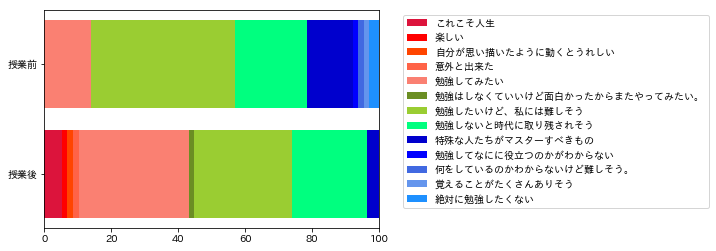

In [10]:
# プログラミングに関する印象をグラフ化
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import numpy as np

before_rate_df = {"answer": [], "before_rate": []}
after_rate_df = {"answer": [], "after_rate": []}

for k, v in count_ba['before'].items():
    before_rate_df['answer'].append(k)
    before_rate_df['before_rate'].append((v / count_before_item) * 100)

for k, v in count_ba['after'].items():
    after_rate_df['answer'].append(k)
    after_rate_df['after_rate'].append((v / count_after_item) * 100)

rate_df = pd.merge(pd.DataFrame(after_rate_df), pd.DataFrame(before_rate_df), on='answer', how='outer').fillna(0).set_index('answer')
print(rate_df)

answer_list = ['これこそ人生', '楽しい', '自分が思い描いたように動くとうれしい', '意外と出来た', '勉強してみたい', '勉強はしなくていいけど面白かったからまたやってみたい。', '勉強したいけど、私には難しそう', '勉強しないと時代に取り残されそう', '特殊な人たちがマスターすべきもの', '勉強してなにに役立つのかがわからない', '何をしているのかわからないけど難しそう。', '覚えることがたくさんありそう', '絶対に勉強したくない']
color_list = ['crimson', 'red', 'orangered', 'tomato', 'salmon', 'olivedrab', 'yellowgreen', 'springgreen', 'mediumblue', 'blue', 'royalblue', 'cornflowerblue', 'dodgerblue']

fig, ax = plt.subplots()
y_pos =  np.arange(len(rate_df.columns))
left_data = pd.Series(np.zeros(len(rate_df.columns)), index=rate_df.columns.tolist())
for ans, color in zip(answer_list,color_list):
    bar_list = ax.barh(y_pos, rate_df.loc[ans], left=left_data, color=color)
    left_data += rate_df.loc[ans]
ax.legend(answer_list, bbox_to_anchor=(2, 1), loc="upper right")
ax.set_xlim([0,100])
ax.set_yticks(y_pos)
ax.set_yticklabels(["授業後", "授業前"])
fig.savefig('./data/png/impression-programming.png', bbox_inches='tight')
fig

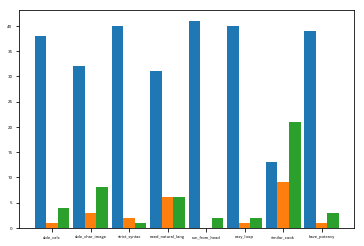

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

bar_labels = ['able_calc', 'able_char_image', 'strict_syntax', 'need_natural_lang', 'run_from_head', 'easy_loop', 'similar_cook', 'have_potency']
bar_data = pd.concat(map(lambda label: interview[label].value_counts(), bar_labels), axis=1, sort=True).fillna(0).reindex(index=['はい', 'いいえ', 'わからない'])

left = np.arange(len(bar_labels))
_left = left
width = 0.3

fig, ax = plt.subplots()
for idx in bar_data.index:
    ax.bar(_left, bar_data.loc[idx], label=idx, width=width)
    _left = width + _left
ax.tick_params(labelsize = 4)
ax.set_xticks(left + width)
ax.set_xticklabels(bar_labels)
fig

/Users/shonanking/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


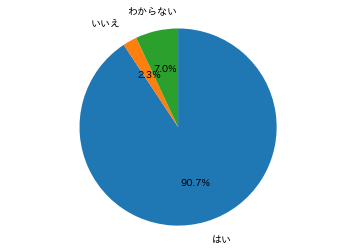

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

bar_labels = ['able_calc', 'able_char_image', 'strict_syntax', 'need_natural_lang', 'run_from_head', 'easy_loop', 'similar_cook', 'have_potency']

for label in bar_labels:
    pie_data = interview[label].value_counts().reindex(index=['はい', 'いいえ', 'わからない']).fillna(0)
    fig, ax = plt.subplots()
    patches, texts, autotexts = ax.pie(pie_data, labels=pie_data.index, counterclock=False, startangle=90, autopct="%1.1f%%", labeldistance=1.2)
    texts[1].set_horizontalalignment('right')
    texts[2].set_horizontalalignment('center')
    ax.axis('equal')
    fig.savefig(f'./data/png/{label}-pie.png')

fig

/Users/shonanking/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


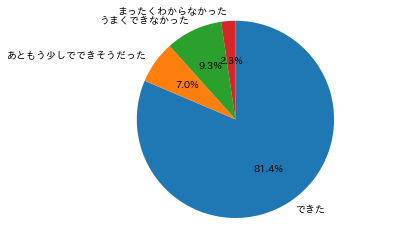

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

pie_data = interview['finish_domino'].value_counts().reindex(index=['できた', 'あともう少しでできそうだった', 'うまくできなかった', 'まったくわからなかった'])
fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(pie_data, labels=pie_data.index, counterclock=False, startangle=90, autopct="%1.1f%%", labeldistance=1.1)
ax.axis('equal')
fig.savefig(f'./data/png/finished_domino-pie.png', bbox_inches='tight')
fig

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

typing_values = ['タッチタイピング（ブラインドタッチ）ができる', 'タッチタイピングはできないが、キーボード入力に不自由を感じない', 'あまりはやくないと自覚しており、はやく入力できるようになりたい', 'できれば、キーボードは触りたくない']

finish_domino_count_by_typing = {}

for tv in typing_values:
    finish_domino_count_by_typing[tv] = interview[interview['typing'] == tv]['finish_domino'].value_counts().reindex(index=['できた', 'あともう少しでできそうだった', 'うまくできなかった', 'まったくわからなかった'])

pd.DataFrame(finish_domino_count_by_typing).fillna(0)

,タッチタイピング（ブラインドタッチ）ができる,タッチタイピングはできないが、キーボード入力に不自由を感じない,あまりはやくないと自覚しており、はやく入力できるようになりたい,できれば、キーボードは触りたくない
できた,3.0,10.0,20,0.0
あともう少しでできそうだった,0.0,0.0,3,0.0
うまくできなかった,0.0,1.0,3,0.0
まったくわからなかった,0.0,0.0,1,0.0


In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

pc_usage_values = ['毎日', '1週間に数回', '1ヶ月に数回', '1学期で数回（レポートを書く時のみ）', 'ほとんど使わない']

finish_domino_count_by_pc_usage = {}

for puv in pc_usage_values:
    finish_domino_count_by_pc_usage[puv] = interview[interview['pc_usage'] == puv]['finish_domino'].value_counts().reindex(index=['できた', 'あともう少しでできそうだった', 'うまくできなかった', 'まったくわからなかった'])

pd.DataFrame(finish_domino_count_by_pc_usage).fillna(0)

,毎日,1週間に数回,1ヶ月に数回,1学期で数回（レポートを書く時のみ）,ほとんど使わない
できた,7.0,6.0,9.0,11.0,0.0
あともう少しでできそうだった,1.0,0.0,0.0,2.0,0.0
うまくできなかった,2.0,0.0,0.0,2.0,0.0
まったくわからなかった,0.0,0.0,1.0,0.0,0.0


In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

experience_values = ['ある', 'ない']

finish_domino_count_by_experience = {}

for ev in experience_values:
    finish_domino_count_by_experience[ev] = interview[interview['experience'] == ev]['finish_domino'].value_counts().reindex(index=['できた', 'あともう少しでできそうだった', 'うまくできなかった', 'まったくわからなかった'])

pd.DataFrame(finish_domino_count_by_experience).fillna(0)

,ある,ない
できた,5.0,28.0
あともう少しでできそうだった,0.0,3.0
うまくできなかった,0.0,4.0
まったくわからなかった,1.0,0.0


In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

df = interview.dropna(subset=['favorite_subject'])

finish_domino_count_by_subject = {}

for item in df.iterrows():
    for subject in item[1]['favorite_subject'].split(','):
        if subject in finish_domino_count_by_subject:
            finish_domino_count_by_subject[subject].append(item[1]['finish_domino'])
        else:
            finish_domino_count_by_subject[subject] = [item[1]['finish_domino']]

for k, v in finish_domino_count_by_subject.items():
    finish_domino_count_by_subject[k] = pd.Series(v).value_counts().reindex(index=['できた', 'あともう少しでできそうだった', 'うまくできなかった', 'まったくわからなかった'])

pd.DataFrame(finish_domino_count_by_subject).fillna(0)[['数学', '理科', '情報', '化学', '体育', '音楽', '英語']]

,数学,理科,情報,化学,体育,音楽,英語
できた,4.0,1.0,1.0,2.0,16.0,18,9.0
あともう少しでできそうだった,0.0,0.0,0.0,0.0,2.0,2,0.0
うまくできなかった,0.0,0.0,0.0,0.0,3.0,2,1.0
まったくわからなかった,0.0,0.0,0.0,0.0,0.0,1,1.0


In [12]:
# エラーの種類ごとの回数も含めたinterview_and_logsを作成
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

interview_and_logs = interview.dropna(subset=['uid']).reset_index()

error_cnt_df = []

for i, uid in enumerate(interview_and_logs['uid']):
    error_cnt = {'last_log_time': None}
    for log in user2logs[uid]:
        error_cnt['last_log_time'] = log['time']
        if (log['type'] == 'compile-error'):
            for v in log['value']:
                error_key = v['key']
                if error_key in error_cnt:
                    error_cnt[error_key] += 1
                else:
                    error_cnt[error_key] = 1
    error_cnt_df.append(error_cnt)

interview_and_logs = pd.concat([interview_and_logs, pd.DataFrame(error_cnt_df).fillna(0)], sort=True, axis=1)
interview_and_logs.to_csv('./data/csv/out-interview-and-logs.csv')
interview_and_logs

,index,timestamp_before,email,pc_usage,typing,experience,experience_langs,experience_timing,experience_time,favorite_subject,...,RecoverP,SyntaxError,SyntaxError/List,TypeError,UndefinedFunction,UndefinedName,UnknownName,Unsupported,Zenkaku,last_log_time
0,0,1/22/2020 13:31:31,yuimuha68@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"数学,歴史,家庭科",...,0.0,6,0.0,0.0,0.0,6,0.0,0.0,0.0,2020-01-22 05:11:50.395000+00:00
1,1,1/22/2020 13:31:42,xxx.drop813@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"美術,数学,英語",...,0.0,24,0.0,0.0,0.0,17,0.0,0.0,1.0,2020-01-22 05:14:21.493000+00:00
2,2,1/22/2020 13:33:19,matomy1006@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"体育,家庭科,音楽",...,0.0,94,0.0,3.0,10.0,27,0.0,0.0,0.0,2020-01-22 05:46:51.978000+00:00
3,3,1/22/2020 13:33:29,kaorim0929@gmail.com,1学期で数回（レポートを書く時のみ）,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"家庭科,歴史,体育",...,0.0,45,27.0,0.0,15.0,25,2.0,0.0,0.0,2020-01-22 05:23:27.169000+00:00
4,4,1/22/2020 13:33:45,nottorimichan@gmail.com,毎日,タッチタイピング（ブラインドタッチ）ができる,ない,NaN,NaN,NaN,"家庭科,数学,英語",...,0.0,115,0.0,0.0,0.0,33,18.0,0.0,1.0,2020-01-22 05:37:50.868000+00:00
5,5,1/22/2020 13:34:18,m.c.coco66@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"体育,音楽,児童文化",...,0.0,143,1.0,2.0,2.0,30,0.0,3.0,0.0,2020-01-22 05:35:22.960000+00:00
6,6,1/22/2020 13:34:19,mocomoco.120123@gmail.com,毎日,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"音楽,体育,世界史",...,0.0,53,1.0,0.0,1.0,40,0.0,0.0,0.0,2020-01-22 05:37:26.057000+00:00
7,7,1/22/2020 13:34:26,momoirodream9863@gmail.com,1学期で数回（レポートを書く時のみ）,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"音楽,歴史,体育",...,0.0,131,0.0,0.0,0.0,40,6.0,0.0,0.0,2020-01-22 05:34:57.347000+00:00
8,8,1/22/2020 13:34:30,maiyui2814@gmail.com,1学期で数回（レポートを書く時のみ）,タッチタイピングはできないが、キーボード入力に不自由を感じない,ない,NaN,NaN,NaN,"体育,音楽,理科",...,0.0,109,0.0,0.0,0.0,60,0.0,0.0,0.0,2020-01-22 05:35:08.658000+00:00
9,9,1/22/2020 13:34:31,tdr.010104@gmail.com,1学期で数回（レポートを書く時のみ）,あまりはやくないと自覚しており、はやく入力できるようになりたい,ない,NaN,NaN,NaN,"体育,音楽,技術",...,0.0,81,1.0,0.0,9.0,44,4.0,0.0,0.0,2020-01-22 05:40:35.650000+00:00


In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

typing_values = ['タッチタイピング（ブラインドタッチ）ができる', 'タッチタイピングはできないが、キーボード入力に不自由を感じない', 'あまりはやくないと自覚しており、はやく入力できるようになりたい', 'できれば、キーボードは触りたくない']

error_means_by_typing = {}

for tv in typing_values:
    error_means_by_typing[tv] = interview_and_logs[interview_and_logs['typing'] == tv][['SyntaxError', 'SyntaxError/List', 'UndefinedFunction', 'UndefinedName', 'UnknownName']].mean()

pd.DataFrame(error_means_by_typing).fillna(0)

,タッチタイピング（ブラインドタッチ）ができる,タッチタイピングはできないが、キーボード入力に不自由を感じない,あまりはやくないと自覚しており、はやく入力できるようになりたい,できれば、キーボードは触りたくない
SyntaxError,93.00,100.363636,98.500000,0.0
SyntaxError/List,0.75,5.000000,3.285714,0.0
UndefinedFunction,4.75,2.636364,4.928571,0.0
UndefinedName,36.75,39.181818,38.785714,0.0
UnknownName,4.50,1.272727,2.142857,0.0


In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

pc_usage_values = ['毎日', '1週間に数回', '1ヶ月に数回', '1学期で数回（レポートを書く時のみ）', 'ほとんど使わない']

error_means_by_pc_usage = {}

for v in pc_usage_values:
    error_means_by_pc_usage[v] = interview_and_logs[interview_and_logs['pc_usage'] == v][['SyntaxError', 'SyntaxError/List', 'UndefinedFunction', 'UndefinedName', 'UnknownName']].mean()

pd.DataFrame(error_means_by_pc_usage).fillna(0)

,毎日,1週間に数回,1ヶ月に数回,1学期で数回（レポートを書く時のみ）,ほとんど使わない
SyntaxError,89.923077,91.166667,83.7,120.071429,0.0
SyntaxError/List,4.692308,5.333333,0.3,3.857143,0.0
UndefinedFunction,3.384615,4.000000,3.6,5.857143,0.0
UndefinedName,35.230769,37.333333,35.9,44.500000,0.0
UnknownName,4.000000,0.666667,1.1,1.785714,0.0


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

finish_domino_values = ['できた', 'あともう少しでできそうだった', 'うまくできなかった', 'まったくわからなかった']

error_means_by_finish_domino = {}

for v in finish_domino_values:
    error_means_by_finish_domino[v] = interview_and_logs[interview_and_logs['finish_domino'] == v][['SyntaxError', 'SyntaxError/List', 'UndefinedFunction', 'UndefinedName', 'UnknownName']].mean()

pd.DataFrame(error_means_by_finish_domino).fillna(0)

,できた,あともう少しでできそうだった,うまくできなかった,まったくわからなかった
SyntaxError,102.400000,112.5,94.0,89.0
SyntaxError/List,3.485714,0.0,7.5,0.0
UndefinedFunction,4.571429,5.0,6.0,0.0
UndefinedName,42.542857,33.5,31.0,34.0
UnknownName,2.028571,3.0,1.5,0.0


In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

experience_values = ['ある', 'ない']

error_means_by_experience = {}

for v in experience_values:
    error_means_by_experience[v] = interview_and_logs[interview_and_logs['experience'] == v][['SyntaxError', 'SyntaxError/List', 'UndefinedFunction', 'UndefinedName', 'UnknownName']].mean()

pd.DataFrame(error_means_by_experience).fillna(0)

,ある,ない
SyntaxError,97.333333,98.648649
SyntaxError/List,0.500000,3.972973
UndefinedFunction,4.000000,4.378378
UndefinedName,40.166667,38.459459
UnknownName,0.333333,2.432432


In [125]:
for log in logs:
    if (log['type'] == 'compile-error'):
        for v in log['value']:
            error_key = v['key']
            if error_key == 'TypeError':
                print(v['subject'])

(1+2)
(1+2)
(1+2)
(126*6)
(126*6)
(126*6)
200
200
200
31
31
31
31
31
31
31
31
31
30
30
30
30
30
30
30
30
10
Rectangle
Rectangle
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
100
1.0
1.0
1.0
100
1.0
1.0
1.0
1.0
1.0
True
True
True
10
True
10
1.0
true
true
true


In [134]:
# プログラミングに関する印象の回答項目の人数比
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import numpy as np

before_rate_df = {"answer": [], "before_rate": []}
after_rate_df = {"answer": [], "after_rate": []}

for k, v in count_ba['before'].items():
    before_rate_df['answer'].append(k)
    before_rate_df['before_rate'].append((v / len(before_interview)) * 100)

for k, v in count_ba['after'].items():
    after_rate_df['answer'].append(k)
    after_rate_df['after_rate'].append((v / len(after_interview)) * 100)

rate_df = pd.merge(pd.DataFrame(after_rate_df), pd.DataFrame(before_rate_df), on='answer', how='outer').fillna(0).set_index('answer')
rate_df

,after_rate,before_rate
answer,,
勉強してみたい,44.186047,19.565217
勉強したいけど、私には難しそう,39.534884,60.869565
勉強しないと時代に取り残されそう,30.232558,30.434783
特殊な人たちがマスターすべきもの,4.651163,19.565217
意外と出来た,2.325581,0.000000
自分が思い描いたように動くとうれしい,2.325581,0.000000
勉強はしなくていいけど面白かったからまたやってみたい。,2.325581,0.000000
これこそ人生,6.976744,0.000000
楽しい,2.325581,0.000000


In [137]:
for com in interview['impression_change'].dropna():
    print(com)

もっと意味の分からない記号や暗号を使うものなのかなと思っていたけど、考えていたよりも簡単にできて、少しだけ身近に感じられることができた
自分のやらせたい動きをプログラミングで実行できるのが面白かった。
思ったより簡単で楽しかった
ザ・ITマンみたいな人がやるものだと思ってたけど、思っていたより全然単純で楽しくて、ちょっとしたゲーム感覚で出来て面白かったです！
全く何も知らない分野でしたが、作れると楽しかったです
難しい印象があったけど、意外と簡単にできるとわかった。
簡単な操作でできて楽しかった。
手順が分かれば意外とスムーズにできた
意外と楽しかったです。
コードを打つところがexcelに似ているなあと思った
ゲームみたいでたのしい！
プログラミングは私には難しくてできないものだと思っていたのですが、実際やってみたら私でも簡単にできることがわかりました。自分が打ち込んだことによって文字が出てきたり円や四角が出てきたりそれらを動かしたりできたのが、すごくすごく楽しかったです。
プログラミングと聞くととても難しいイメージを持っていたけど、簡単なものだったら自分にもできるんだと思った。
楽しかったです。
プログラミングは専門的なものだと思っていたが、初心者でも楽しむことの出来るものであることが分かった。
思ったより楽しかったです。
以前違う場所で習ったときから苦手意識を持っていたが、今回の授業を通して、基本的な操作が分かれば難しくはないということを理解でき、楽しく学ぶことができた。
数式を入れていくだけの難しいものだと思っていたけどそこまで難しくなくて私でもがんばればできるものなんだとちょっとびっくりした。
意外と簡単にできて楽しかった
思ったより簡単で楽しかったでーす
思ったより簡単で、楽しかったです。
意外と簡単で面白い
思っていた以上に楽しかった！
プログラミングはもっと難しいものだと思っていたが、勉強すれば理解できると思った。
意外と簡単だった、機械を操作するものだと思っていたけどほかにもあるんだと分かった
人生を見つけた
自分には難しいものと思っていましたが、想像以上に単純作業の繰り返しだと思いました。勉強すれば、自分にもできそうだと感じました。
０から作ることは難しいがpuppyのように枠組みがあれば、誰でも簡単にプログラミングを作ることができることに驚いた

In [139]:
interview["pc_usage"].value_counts().reindex(index=['毎日', '1週間に数回', '1ヶ月に数回', '1学期で数回（レポートを書く時のみ）', 'ほとんど使わない']).fillna(0)

毎日                    13
1週間に数回                 6
1ヶ月に数回               11
1学期で数回（レポートを書く時のみ）    15
ほとんど使わない               1
Name: pc_usage, dtype: int64

In [141]:
interview["typing"].value_counts().reindex(index=['タッチタイピング（ブラインドタッチ）ができる', 'タッチタイピングはできないが、キーボード入力に不自由を感じない', 'あまりはやくないと自覚しており、はやく入力できるようになりたい', 'できれば、キーボードは触りたくない']).fillna(0)

タッチタイピング（ブラインドタッチ）ができる              5.0
タッチタイピングはできないが、キーボード入力に不自由を感じない    11.0
あまりはやくないと自覚しており、はやく入力できるようになりたい    30.0
できれば、キーボードは触りたくない                   0.0
Name: typing, dtype: float64

In [142]:
interview["finish_domino"].value_counts().fillna(0)

できた               35
うまくできなかった          4
あともう少しでできそうだった     3
まったくわからなかった        1
Name: finish_domino, dtype: int64

In [2]:
35/46

0.7608695652173914